# Image Deblurring

I implement a deblurring pipeline on GoPro with three models: a residual CNN baseline, a generalized UNet, and a simplified NAFNet.

<img src="images/blur.png">

In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


## Setup & Data

In [ ]:
from utils import download_from_yadisk, test_model
import os

TARGET_DIR = '.'
FILENAME = "GoPro.zip"

if not os.path.exists(os.path.join(TARGET_DIR, FILENAME)):
    # we are going to download 5.2 gb file, downloading will take some time
    download_from_yadisk(
        short_url='https://disk.yandex.ru/d/v7O5TOsstnsscw',
        filename=FILENAME,
        target_dir=TARGET_DIR
    )

In [ ]:
!unzip -qq GoPro.zip

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.utils import make_grid

from torchvision import transforms
from PIL import Image
import os
from utils import download_from_yadisk, test_model
import torch
import torch.nn as nn
import torch.nn.functional as F


print(f"GPU: {torch.cuda.is_available()}")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

GPU: True


## Dataset

I prepare GoPro train/val/test splits with Albumentations augmentations. I keep shapes and types consistent.

In [5]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pathlib import Path

class GoProDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        blur_path = Path(f"{root_dir}/blur")
        sharp_path = Path(f"{root_dir}/sharp")
        self.blurry_images = [p.name for p in list(blur_path.glob("*.png"))]

    def __len__(self):
        return len(self.blurry_images)

    def __getitem__(self, idx):
        blurry_path = Path(self.root_dir, 'blur', self.blurry_images[idx])
        sharp_path = Path(self.root_dir, 'sharp', self.blurry_images[idx])

        blurry_image = np.array(Image.open(blurry_path).convert('RGB'))
        sharp_image = np.array(Image.open(sharp_path).convert('RGB'))

        if self.transform:
            blurry_image = blurry_image.astype(np.float32)/255.0
            sharp_image = sharp_image.astype(np.float32)/255.0
            augmented = self.transform(image=blurry_image, image1=sharp_image)
            blurry_image = augmented['image']
            blurry_image = blurry_image.to(torch.float32)
            sharp_image = augmented['image1']
            sharp_image = sharp_image.to(torch.float32)

        return blurry_image, sharp_image

transform = A.Compose([
    A.RandomCrop(256, 256, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    ToTensorV2(),
], additional_targets={
        'image1': 'image'}, p=1)

transform_test = A.Compose([
    ToTensorV2(),
], additional_targets={
        'image1': 'image'}, p=1)

train_dataset = GoProDataset(root_dir='GoPro/train', transform=transform)
# train_dataloader = DataLoader(train_dataset, batch_size=3, shuffle=True, num_workers=16)

test_dataset = GoProDataset(root_dir='GoPro/test', transform=transform_test)
# test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

/home/threeteck/miniforge3/envs/deblur_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from torch.utils.data import SubsetRandomSampler

# Split the training dataset into training and validation sets
train_size = int(1 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_dataloader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, num_workers=16,
    pin_memory=True, persistent_workers=True, drop_last=True
)
val_dataloader = DataLoader(
    val_dataset, batch_size=32, shuffle=False, num_workers=16,
    pin_memory=True, persistent_workers=True
)
# Keep the test dataloader as it is
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


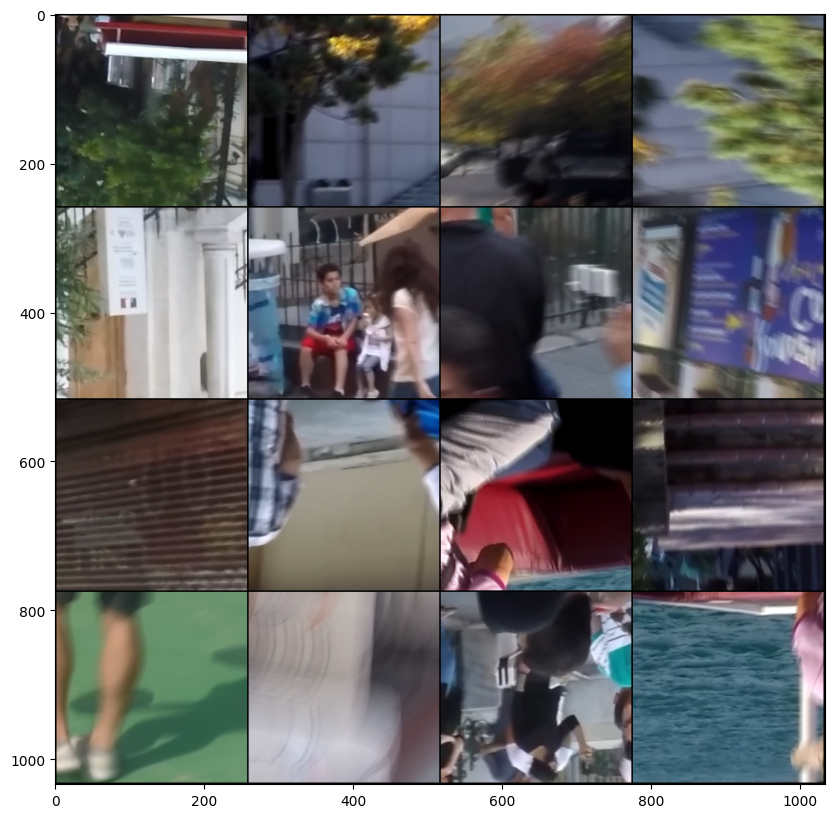

In [7]:
samples = torch.stack([train_dataset[i][0] for i in range(32, 48)], dim=0)

plt.figure(figsize=(10, 10))
plt.imshow(make_grid(samples, nrow=4).permute(1, 2, 0))
plt.show()

### PSNR Loss 

I will directly optimize the PSNR quality metric instead of plain MSE  
$PSNR = 10 * \log_{10}(\frac{MAX_I^2}{MSE})$  
In out case the images are normed to [0, 1], so the $MAX_I=1$

When averaging, i first calculate the MSE for each pair of images, only then apply log and after that i average along batch axis.

In [8]:
class PSNRLoss(nn.Module):
    def __init__(self):
        """Peak signal-to-noise ratio loss function?
        """
        super().__init__()
        self.eps = 1e-12  # use eps to prevent 0 in log

    def forward(self, pred, target):

        # along height, width, and channel dimensions
        mse = torch.mean((pred - target) ** 2, dim=(1, 2, 3)) 
        # Apply log and calculate mean
        psnr = 10 * torch.mean(torch.log10(mse + self.eps))

        return psnr

In [9]:
criterion = PSNRLoss()
a = torch.tensor([[[[0.1632, 0.0024, 0.9913, 0.8892],
          [0.5655, 0.4472, 0.4592, 0.2013],
          [0.7722, 0.9089, 0.1708, 0.3654],
          [0.6147, 0.9567, 0.7018, 0.2376]]]])
b = torch.tensor([[[[0.8498, 0.1168, 0.3987, 0.6781],
          [0.7864, 0.9762, 0.3694, 0.9926],
          [0.9000, 0.0293, 0.0454, 0.0984],
          [0.9478, 0.3730, 0.9617, 0.5052]]]])

#simple assert to check the PSNR function
assert torch.isclose(criterion(a, b), torch.tensor(-6.8417))

### Training
Basic training pipeline.

Note that i use gradient clipping, while not required to train the simplest model it will greately help for later parts the work (helps later for deeper models).

In [10]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from utils import get_scheduler
import wandb



In [ ]:
def train_model(model, train_dataloader, optimizer, criterion, scheduler, sch=False, num_epochs=200, patience=48, min_delta=5e-3, save_best=True, checkpoints_path="./checkpoints", use_grad_clip=True):
    # Create checkpoints folder
    PATH = checkpoints_path
    os.makedirs(PATH, exist_ok = True)
    l2_fn = nn.MSELoss()

    best_psnr = 0
    epochs_since_improve = 0
    
    # Training loop
    for epoch in range(num_epochs):
        MSELosses = []
        PSNRs =[]
        # Create tqdm progress bar
        pbar = tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}]", ncols=120, leave=True)

        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs = inputs.to(device)
            targets = targets.to(device)
            #set gradient to zero
            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            l_2 = l2_fn(outputs, targets)
            PSNRs.append(loss.item())
            MSELosses.append(l_2.item())

            # Backward pass
            loss.backward()

            # Gradient clipping
            if use_grad_clip:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=.05)

            optimizer.step()

            if (batch_idx % 16 == 0) or (batch_idx == len(train_dataloader) - 1):
                pbar.set_postfix({
                    "MSELoss": f"{float(np.mean(MSELosses)):.6f}",
                    "PSNR": f"{float(np.mean(PSNRs)):.6f}",
                    "LR": f"{optimizer.param_groups[0]['lr']:.6g}"
                })

        epoch_mse  = float(np.mean(MSELosses))
        epoch_psnr = float(np.mean(PSNRs))

        # ---- early stopping on PSNR loss (lower is better) ----
        improved = (best_psnr - epoch_psnr) > min_delta
        if improved:
            best_psnr = epoch_psnr
            epochs_since_improve = 0

            if save_best:
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_psnr_loss': best_psnr,
                }, os.path.join(PATH, "best.pt"))
        else:
            epochs_since_improve += 1

        # torch.save({
        #           'epoch': epoch,
        #           'model_state_dict': model.state_dict(),
        #           'optimizer_state_dict': optimizer.state_dict()
        #           }, os.path.join(PATH, f"epoch_{epoch+1}.tar"))


        if sch : scheduler.step()
        lr = optimizer.param_groups[0]['lr']
        # pbar.close()
        # ---- W&B: log only the two losses per epoch ----
        # wandb.log({
        #     "train/mse": epoch_mse,
        #     "train/psnr_loss": epoch_psnr, 
        #     "epoch": epoch + 1
        # })
        if epochs_since_improve >= patience:
            torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'last_psnr_loss': epoch_psnr,
            }, os.path.join(checkpoints_path, "last.pt"))

            print(f"Early stopping at epoch {epoch+1}: no PSNR loss improvement for {patience} epochs. "
                  f"Best PSNR loss: {best_psnr:.6f}")
            break
    torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'last_psnr_loss': epoch_psnr,
    }, os.path.join(checkpoints_path, "last.pt"))

    return model

## NAFNet

I mentioned that many architectures build upon **UNet** by modifying individual blocks. One notable example is [NAFNet](https://arxiv.org/abs/2204.04676), which for quite some time held state-of-the-art performance in image deblurring even though the authors originally presented it as a baseline model.  

Some of the main design choices behind NAFNet include:  
- Removing traditional nonlinearities (no ReLU, GELU, ELU, etc.)  
- Using a simplified form of channel attention  
- Replacing BatchNorm with LayerNorm  
- Incorporating several training strategies inspired by transformer papers  

In spirit, this approach is somewhat similar to [ConvNeXt](https://arxiv.org/abs/2201.03545), where the authors revisited ResNet and refined it with modern training techniques to achieve state-of-the-art results in classification.  

Now I’ll move on to implementing **NAFNet** 

### Simple gate block

<img src="images/gate.png">

Instead of using regular non-linearities  [NAFNet](https://arxiv.org/abs/2204.04676) proposes the use of "Simple Gates" which perform pointwise multiplication of feature maps.

Simple gate layer splits input feature map in 2 part along the channel axis and multiplies them.

I use [`torch.chunk`](https://pytorch.org/docs/stable/generated/torch.chunk.html) to split the input in 2

In [13]:
class SimpleGate(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        """
            Split the input in 2, along the channel axis
            Return multiplication of these 2 parts
        """
        # Split the input tensor along the channel axis
        part1, part2 = torch.chunk(x, 2, dim=1)
        # Multiply the two parts element-wise
        output = torch.mul(part1, part2)

        return output

In [14]:
block = SimpleGate()
vec = torch.rand(16, 64, 256, 256)
assert block(vec).shape == torch.Size([16, 32, 256, 256])

### NAFNet up block

In [15]:
class NAFNetUpBlock(nn.Module):
    def __init__(self, channels):
        """NAFNet upsampling block
            conv 1x1 (chan, 2 * chan)
            pixelshuffle(2)

        """
        super(NAFNetUpBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels * 2, kernel_size=1, bias=False)  # Pointwise Convolution to double channel width
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pixel_shuffle(x)
        return x

In [16]:
block = NAFNetUpBlock(64)
vec = torch.rand(16, 64, 256, 256)
assert block(vec).shape == torch.Size([16, 32, 512, 512])

### NAFNet down block

In [17]:
class NAFNetDownBlock(nn.Module):
    def __init__(self, channels):
        """NAFNet downsampling block
            conv with stride 2, **mind the padding**

        """
        super().__init__()
        self.conv = nn.Conv2d(channels, channels * 2, kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        return x


In [18]:
block = NAFNetDownBlock(64)
vec = torch.rand(16, 64, 256, 256)
assert block(vec).shape == torch.Size([16, 128, 128, 128])

### Simplified Channel Attention in NAFNet

In regular channel attention mechanisms, the weights for each channel of the input feature map are produced using a small 2-layer MLP.  
The authors of [NAFNet](https://arxiv.org/abs/2204.04676) simplified this step by removing the MLP entirely.  

Instead, they apply global pooling to the feature map and then use a simple linear projection to obtain the channel weights.  
This makes the block lighter and more efficient, while still capturing useful channel information.  

<img src="images/sca.png">

In [19]:
class SCA(nn.Module):
    def __init__(self, in_channels, out_channels):
        """Simplified channel attention module

            adaptiveavgpool to get 1x1 feature map
            conv 1x1 projection layer

        """
        super().__init__()

        self.adaptive_pool = nn.AdaptiveAvgPool2d(1)
        self.sca = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0, stride=1,
                  groups=1, bias=True)

    def forward(self, x):
        """
            Return only the attention weights
        """
        att_weights = self.sca(x)
        x = self.adaptive_pool(att_weights)
        return att_weights

In [20]:
block = SCA(64, 32)
vec = torch.rand(16, 64, 256, 256)
assert block(vec).shape == torch.Size([16, 32, 256, 256])

In [21]:
block(vec).shape

torch.Size([16, 32, 256, 256])

### NAFNet block

The diagram shows the intra-block structure:

<img src="images/nafnet_block.png" width=620>

Note the use of learnable skip-connection scales `beta` and `gamma`, use [`nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html)

<img src="https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html"/>



In [22]:
from utils import LayerNorm2d  # 

class NAFNetBlock(nn.Module):
    def __init__(self, c, DW_Expand=2, FFN_Expand=2, drop_out_rate=0.):
        super().__init__()

        dw_channel = c * DW_Expand
        ffn_channel = FFN_Expand * c

        self.conv1 = nn.Conv2d(in_channels=c, out_channels=dw_channel, kernel_size=1, padding=0, stride=1, groups=1, bias=True)
        self.conv2 = nn.Conv2d(in_channels=dw_channel, out_channels=dw_channel, kernel_size=3, padding=1, stride=1, groups=dw_channel,
                               bias=True)
        self.conv3 = nn.Conv2d(in_channels=dw_channel // 2, out_channels=c, kernel_size=1, padding=0, stride=1, groups=1, bias=True)

        # Simplified Channel Attention
        self.sca = SCA(in_channels=dw_channel // 2, out_channels=dw_channel // 2)

        # SimpleGate
        self.sg = SimpleGate()

        ffn_channel = FFN_Expand * c
        self.conv4 = nn.Conv2d(in_channels=c, out_channels=ffn_channel, kernel_size=1, padding=0, stride=1, groups=1, bias=True)
        self.conv5 = nn.Conv2d(in_channels=ffn_channel // 2, out_channels=c, kernel_size=1, padding=0, stride=1, groups=1, bias=True)

        self.norm1 = LayerNorm2d(c)
        self.norm2 = LayerNorm2d(c)

        self.dropout1 = nn.Dropout(drop_out_rate) if drop_out_rate > 0. else nn.Identity()
        self.dropout2 = nn.Dropout(drop_out_rate) if drop_out_rate > 0. else nn.Identity()

        self.beta = nn.Parameter(torch.zeros((1, c, 1, 1)), requires_grad=True)
        self.gamma = nn.Parameter(torch.zeros((1, c, 1, 1)), requires_grad=True)


    def forward(self, inp):

        x = inp
        x = self.norm1(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.sg(x)
        x = x * self.sca(x)
        x = self.conv3(x)
        x = self.dropout1(x)
        y = inp + x * self.beta
        x = self.conv4(self.norm2(y))
        x = self.sg(x)
        x = self.conv5(x)

        x = self.dropout2(x)

        return y + x * self.gamma

In [23]:
block = NAFNetBlock(64)
vec = torch.rand(16, 64, 256, 256)
assert block(vec).shape == torch.Size([16, 64, 256, 256])

### NAFNet — full model

In [24]:
class GeneralizedNAFNet(nn.Module):

    def __init__(self,NAFNetBlock, NAFNetDownBlock, NAFNetUpBlock, img_channel=3, width=36, middle_blk_num=1, enc_blk_nums=[], dec_blk_nums=[]):
        super().__init__()
        self.intro = nn.Conv2d(in_channels=img_channel, out_channels=width, kernel_size=3, padding=1, stride=1, groups=1,
                              bias=True).to(device)
        self.ending = nn.Conv2d(in_channels=width, out_channels=img_channel, kernel_size=3, padding=1, stride=1, groups=1,
                              bias=True).to(device)

        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        self.middle_blks = nn.ModuleList().to(device)
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()

        chan = width
        for num in enc_blk_nums:
            self.encoders.append(
                nn.Sequential(
                    *[NAFNetBlock(chan) for _ in range(num)]
                )
            )
            self.downs.append(
                NAFNetDownBlock(chan)
            )
            chan = chan * 2

        self.middle_blks = \
            nn.Sequential(
                *[NAFNetBlock(chan) for _ in range(middle_blk_num)]
            )

        for num in dec_blk_nums:
            self.ups.append(NAFNetUpBlock(chan)
            )
            chan = chan // 2
            self.decoders.append(
                nn.Sequential(
                    *[NAFNetBlock(chan) for _ in range(num)]
                )
            )

        self.padder_size = 2 ** len(self.encoders)

    def forward(self, inp):
        B, C, H, W = inp.shape
        inp = self.check_image_size(inp)

        x = self.intro(inp)

        encs = []

        for encoder, down in zip(self.encoders, self.downs):
            x = encoder(x)
            encs.append(x)
            x = down(x)

        x = self.middle_blks(x)

        for decoder, up, enc_skip in zip(self.decoders, self.ups, encs[::-1]):
            x = up(x)
            x = x + enc_skip
            x = decoder(x)

        x = self.ending(x)
        x = x + inp

        return x[:, :, :H, :W]

    def check_image_size(self, x):
        _, _, h, w = x.size()
        mod_pad_h = (self.padder_size - h % self.padder_size) % self.padder_size
        mod_pad_w = (self.padder_size - w % self.padder_size) % self.padder_size
        x = F.pad(x, (0, mod_pad_w, 0, mod_pad_h))
        return x


### Train NAFNet

In [25]:
model = GeneralizedNAFNet(NAFNetBlock, NAFNetDownBlock, NAFNetUpBlock, enc_blk_nums=[1,2,2,28], dec_blk_nums=[2,2,2,1])
model.to(device)
vec = torch.rand(2, 3, 256, 256).to(device)
assert model(vec).shape == torch.Size([2, 3, 256, 256])

In [26]:
torch.cuda.empty_cache()

In [27]:
torch.manual_seed(11)

model = GeneralizedNAFNet(NAFNetBlock, NAFNetDownBlock, NAFNetUpBlock, enc_blk_nums=[1,2,2,28], dec_blk_nums=[2,2,2,1])
model = model.to(device)

criterion = PSNRLoss()
#criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.9))
use_grad_clip = True
scheduler = get_scheduler(optimizer)

train_model(model, train_dataloader, optimizer, criterion, scheduler, sch=True, num_epochs=200, use_grad_clip=use_grad_clip)

Epoch [200/200]: 100%|███████████████| 65/65 [01:01<00:00,  1.06it/s, MSELoss=0.001655, PSNR=-30.429981, LR=1.72298e-06]


In [28]:
from utils import test_model
test_model(model, device, test_dataloader)

100%|██████████| 634/634 [05:24<00:00,  1.96it/s]

Mean MSE: 0.001360672408913843
Mean PSNR: -29.749051484010813
Mean SSIM: 0.8832805752754211


(np.float64(0.001360672408913843),
 np.float64(-29.749051484010813),
 np.float32(0.8832806))

## Check model results

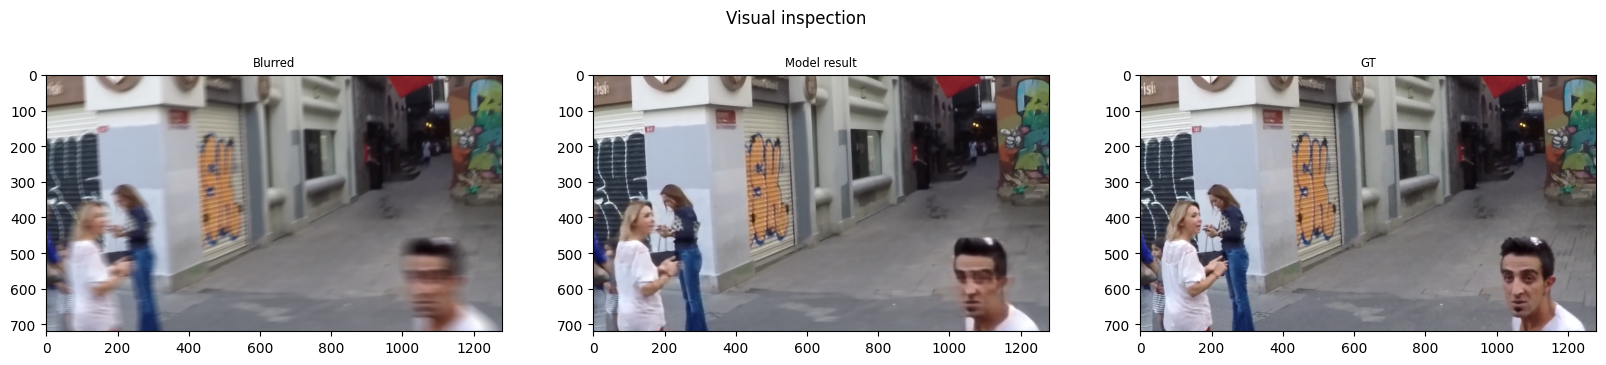

In [30]:
pics = test_dataset[2]
blurred, gt = pics[0], pics[1]
plt.figure(figsize=(20, 4))
plt.suptitle("Visual inspection")
plt.subplot(131)
plt.title("Blurred")
plt.imshow(blurred.permute(1, 2, 0))
plt.subplot(132)
plt.title("Model result")
with torch.no_grad():
    output = model(blurred.unsqueeze(0).to(device)).cpu().squeeze(0).permute(1, 2, 0).numpy()
output = np.clip(output, 0, 1)
plt.imshow(output)
plt.subplot(133)
plt.imshow(gt.permute(1, 2, 0))
plt.title("GT")
plt.show()